# Parte 2: Aprendizaje Semisupervisado para Clasificación de Rating

Este notebook implementa un protocolo de aprendizaje semisupervisado utilizando el dataset procesado, con baseline supervisado, Self-Training y Label Spreading/Propagation (k-NN). Incluye EDA, configuración experimental, evaluación con métricas solicitadas y análisis de hiperparámetros.

In [1]:
# Instalación de dependencias necesarias (ejecutar una vez)
import sys, subprocess
packages = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'scipy'
]
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + packages)
print('Instalación de dependencias completada')

Instalación de dependencias completada


In [2]:
# Descarga y preparación del dataset
import os
import pandas as pd
from urllib.request import urlretrieve

# Crear directorios si no existen
os.makedirs('../data/processed', exist_ok=True)
dataset_path = '../data/processed/dataset.csv'

# Descargar el dataset si no existe
if not os.path.exists(dataset_path):
    print("Descargando dataset...")
    url = 'https://raw.githubusercontent.com/martin2000002/Proyecto-ML-202510-Data/main/dataset.csv'
    try:
        urlretrieve(url, dataset_path)
        print(f"Dataset descargado exitosamente en {dataset_path}")
    except Exception as e:
        print(f"Error al descargar el dataset: {e}")
        # Crear un DataFrame vacío para evitar errores en celdas posteriores
        pd.DataFrame().to_csv(dataset_path)
        print(f"Se ha creado un archivo CSV vacío en {dataset_path}")
else:
    print(f"El dataset ya existe en {dataset_path}")

El dataset ya existe en ../data/processed/dataset.csv


##SMOTE (Synthetic Minority Over-sampling Technique)
genera ejemplos sintéticos interpolando entre vecinos cercanos de la misma clase. Lo usamos para incrementar el numero de muestras para mejorar el entrenamiento y reducir los NaN en AUC.

In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder

# Cargar dataset
df = pd.read_csv("/data/processed/dataset.csv")

print("="*60)
print("ANÁLISIS DEL DATASET ORIGINAL")
print("="*60)
print(f"Tamaño: {df.shape}")
print(f"\nDistribución de clases:")
class_dist = df['label'].value_counts().sort_index()
print(class_dist)

# Separar features y target
X = df.drop(['cooperativa', 'abreviacion', 'label'], axis=1)
y = df['label']

# Codificar labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\n{'='*60}")
print("ESTRATEGIA DE AUMENTO EN 2 ETAPAS")
print("="*60)
print("Etapa 1: RandomOverSampler para llevar clases con 1 muestra a 3 muestras")
print("         (duplicación simple para tener suficientes vecinos)")
print("Etapa 2: SMOTE para generar ejemplos sintéticos y balancear todas las clases")

# ETAPA 1: Usar RandomOverSampler para clases con muy pocas muestras
# Llevar AAA, B, BB de 1 → 3 muestras
ros = RandomOverSampler(
    sampling_strategy={
        le.transform(['AAA'])[0]: 3,  # AAA: 1 -> 3
        le.transform(['B'])[0]: 3,    # B: 1 -> 3
        le.transform(['BB'])[0]: 3,   # BB: 1 -> 3
    },
    random_state=42
)

X_ros, y_ros = ros.fit_resample(X, y_encoded)

print(f"\nDespués de Etapa 1 (RandomOverSampler):")
y_ros_decoded = le.inverse_transform(y_ros)
print(pd.Series(y_ros_decoded).value_counts().sort_index())

# ETAPA 2: Aplicar SMOTE con k_neighbors=2 (ahora todas las clases tienen >= 3 muestras)
smote = SMOTE(
    random_state=42,
    k_neighbors=2,        # ahora es seguro usar k=2
    sampling_strategy='auto'  # balancea todas a la clase mayoritaria
)

X_resampled, y_resampled = smote.fit_resample(X_ros, y_ros)

# Decodificar labels
y_resampled = le.inverse_transform(y_resampled)

# Crear dataset aumentado
df_augmented = pd.DataFrame(X_resampled, columns=X.columns)
df_augmented['label'] = y_resampled   # mantenemos el mismo nombre de columna

print(f"\n{'='*60}")
print("DATASET AUMENTADO - 6 CLASES BALANCEADAS")
print("="*60)
print(f"Tamaño original: {len(df)} muestras")
print(f"Tamaño aumentado: {len(df_augmented)} muestras")
print(f"Factor de aumento: {len(df_augmented) / len(df):.2f}x")

print(f"\nDistribución original:")
print(class_dist)

print(f"\nDistribución aumentada (balanceada):")
augmented_dist = df_augmented['label'].value_counts().sort_index()
print(augmented_dist)

print(f"\n{'='*60}")
print("COMPARACIÓN POR CLASE")
print("="*60)
comparison = pd.DataFrame({
    'Original': class_dist,
    'Aumentado': augmented_dist,
    'Incremento': augmented_dist - class_dist,
    'Factor': (augmented_dist / class_dist).round(1)
})
print(comparison)

# Guardar dataset aumentado
df_augmented.to_csv("/data/processed/dataset_augmented_6classes.csv", index=False)

print(f"\n✅ Dataset guardado como 'dataset_augmented_6classes.csv'")

# Verificar calidad
print(f"\n{'='*60}")
print("VERIFICACIÓN DE CALIDAD")
print("="*60)
print(f"NaN en features: {df_augmented[X.columns].isna().sum().sum()}")
print(f"NaN en label: {df_augmented['label'].isna().sum()}")
print(f"Clases únicas: {df_augmented['label'].nunique()}")
print(f"Todas las 6 clases presentes: {set(df_augmented['label']) == set(df['label'])}")

# Mostrar algunas estadísticas
print(f"\n{'='*60}")
print("MUESTRA DE DATOS SINTÉTICOS (primeras 5 filas)")
print("="*60)
print(df_augmented.head())

print(f"\n{'='*60}")
print("RECOMENDACIÓN PARA TU NOTEBOOK:")
print("="*60)
print("✓ Usa 'dataset_augmented_6classes.csv' en lugar de 'dataset.csv'")
print("✓ Mantiene las 6 clases originales: A, AA, AAA, B, BB, BBB")
print(f"✓ {len(df_augmented)} muestras balanceadas ({augmented_dist.iloc[0]} por clase)")
print("✓ Combina duplicación simple + SMOTE para máxima diversidad")

ANÁLISIS DEL DATASET ORIGINAL
Tamaño: (42, 15)

Distribución de clases:
label
A      12
AA     15
AAA     1
B       1
BB      1
BBB    12
Name: count, dtype: int64

ESTRATEGIA DE AUMENTO EN 2 ETAPAS
Etapa 1: RandomOverSampler para llevar clases con 1 muestra a 3 muestras
         (duplicación simple para tener suficientes vecinos)
Etapa 2: SMOTE para generar ejemplos sintéticos y balancear todas las clases

Después de Etapa 1 (RandomOverSampler):
A      12
AA     15
AAA     3
B       3
BB      3
BBB    12
Name: count, dtype: int64

DATASET AUMENTADO - 6 CLASES BALANCEADAS
Tamaño original: 42 muestras
Tamaño aumentado: 90 muestras
Factor de aumento: 2.14x

Distribución original:
label
A      12
AA     15
AAA     1
B       1
BB      1
BBB    12
Name: count, dtype: int64

Distribución aumentada (balanceada):
label
A      15
AA     15
AAA    15
B      15
BB     15
BBB    15
Name: count, dtype: int64

COMPARACIÓN POR CLASE
       Original  Aumentado  Incremento  Factor
label                

In [4]:
# Configuración general
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, balanced_accuracy_score, confusion_matrix,
                             roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading, LabelPropagation

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = os.path.join('..', 'data', 'processed', 'dataset_augmented_6classes.csv')
assert os.path.exists(DATA_PATH), f'No se encuentra el dataset en {DATA_PATH}'
df = pd.read_csv(DATA_PATH)
df.head()

,activos_productivos_sobre_total_activos,activos_productivos_sobre_pasivos_con_costo,morosidad_cartera_productiva,morosidad_total,cobertura_cartera_problematica,cartera_refinanciada,cartera_reestructurada,gastos_operativos_sobre_activos,roa,roe,cartera_sobre_depositos,margen_intermediacion_sobre_activo_promedio,label
0,0.876898,1.027844,0.111285,0.107272,1.023424,0.144911,0.157736,0.055945,0.000585,0.005227,0.792486,-0.014466,BB
1,0.908252,1.044289,0.020040,0.093425,1.076982,0.162655,0.179990,0.043137,0.001484,0.013795,0.796689,-0.010111,A
2,0.926584,1.039765,0.055395,0.099000,1.080869,0.146202,0.137274,0.029980,0.000520,0.005820,0.856153,-0.001481,AA
3,0.921099,1.080646,0.000000,0.096313,0.963912,0.212391,0.249426,0.038264,0.000738,0.006256,0.822414,-0.004091,A
4,0.905735,1.014125,0.080890,0.067223,1.019509,0.197214,0.164180,0.043149,0.001185,0.012872,0.871291,0.000183,BBB


## Estructura de datos y selección de variables
- Las columnas de identificación `cooperativa` y `abreviacion` no se usan como features.
- La columna de label es `Label`.
- Se asume que los demás campos numéricos están preprocesados.

In [5]:
# Definición de columnas y división X / y
id_cols = ['cooperativa', 'abreviacion']
label_col = 'label'
assert label_col in df.columns, 'No se encontró la columna de label esperada'
feature_cols = [c for c in df.columns if c not in id_cols + [label_col]]
X = df[feature_cols].copy()
y = df[label_col].astype(str).copy()
classes_ = np.unique(y)
n_classes = len(classes_)
X.shape, y.value_counts().to_dict()

((90, 12), {'BB': 15, 'A': 15, 'AA': 15, 'BBB': 15, 'AAA': 15, 'B': 15})

## EDA: Distribuciones, correlaciones y t-SNE
Exploramos la distribución de indicadores, correlaciones y redundancias, y visualizamos con t-SNE.

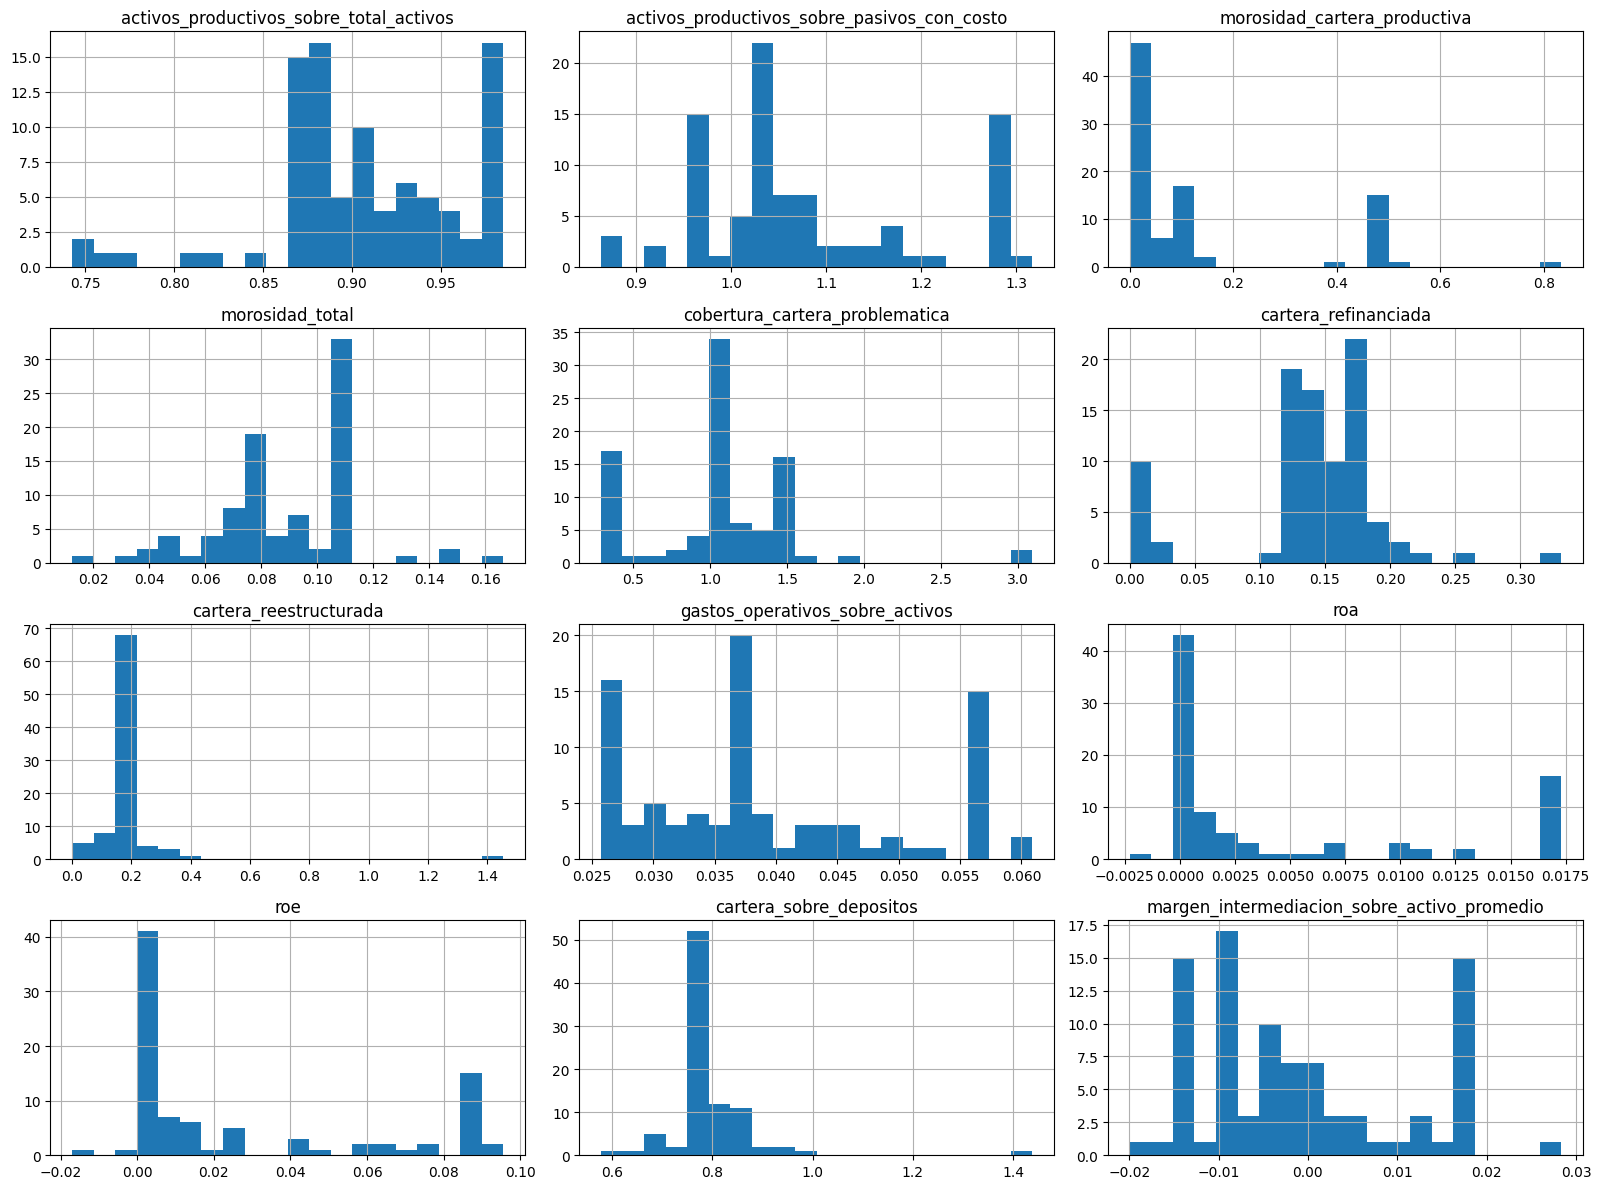

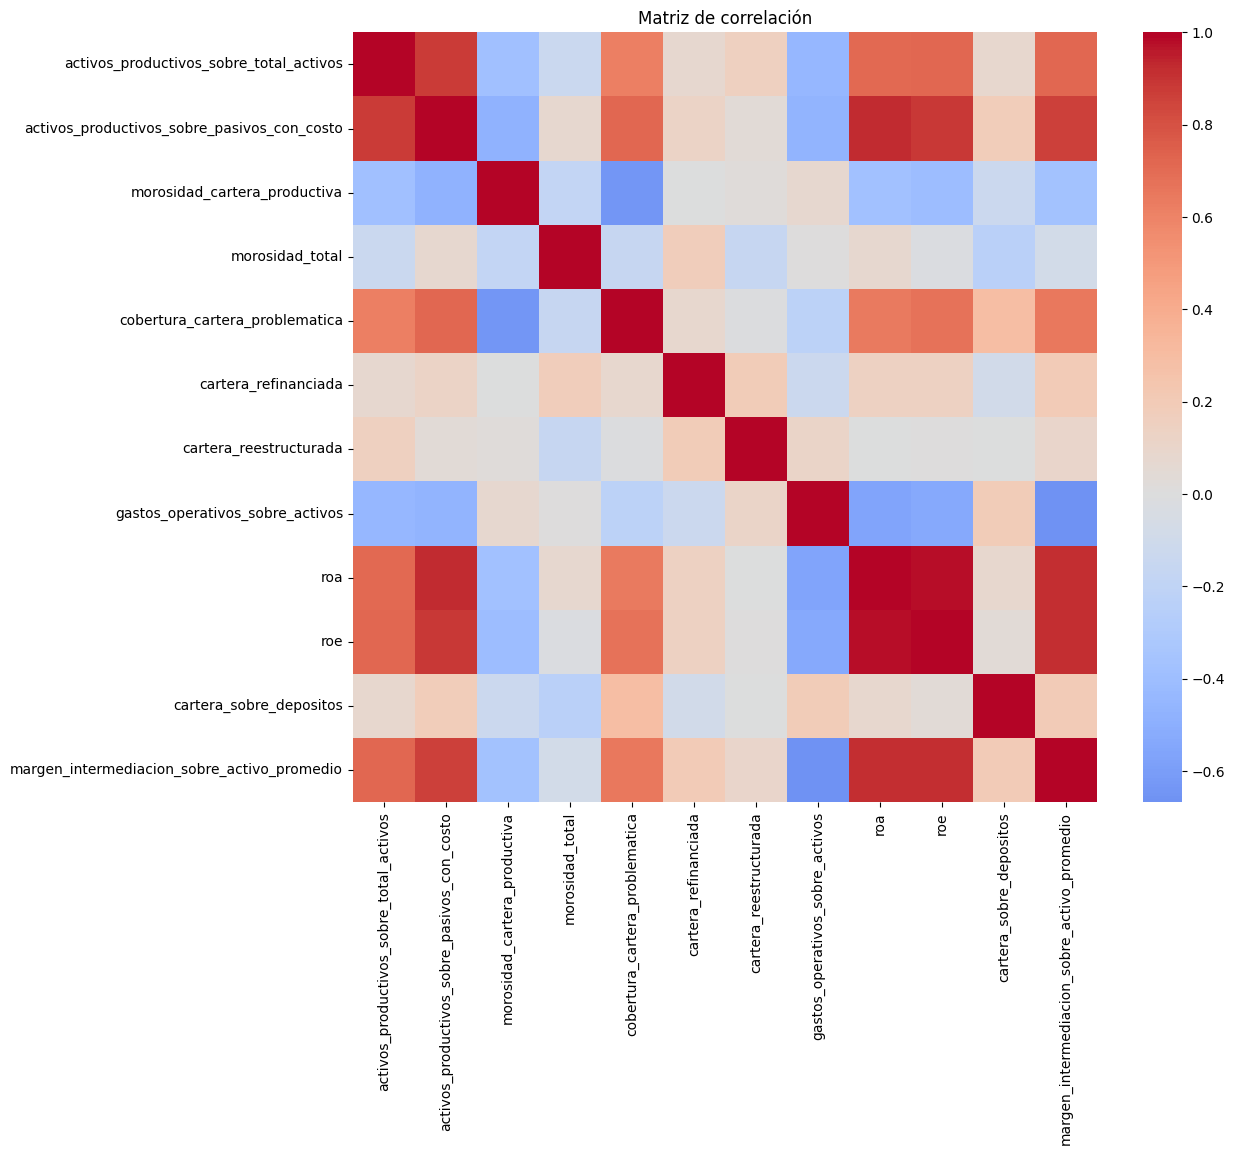

,feat1,feat2,corr
1,roa,roe,0.973999
0,activos_productivos_sobre_pasivos_con_costo,roa,0.923261
2,roa,margen_intermediacion_sobre_activo_promedio,0.918543
3,roe,margen_intermediacion_sobre_activo_promedio,0.909593


In [6]:
# Distribución de indicadores (histogramas)
_ = X.hist(figsize=(16, 12), bins=20)
plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(12,10))
corr = X.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.show()

# Redundancias: pares con |corr| > 0.9
high_corr = []
thr = 0.9
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if j <= i:
            continue
        val = corr.loc[c1, c2]
        if abs(val) > thr:
            high_corr.append((c1, c2, float(val)))
pd.DataFrame(high_corr, columns=['feat1','feat2','corr']).sort_values('corr', key=lambda s: s.abs(), ascending=False)


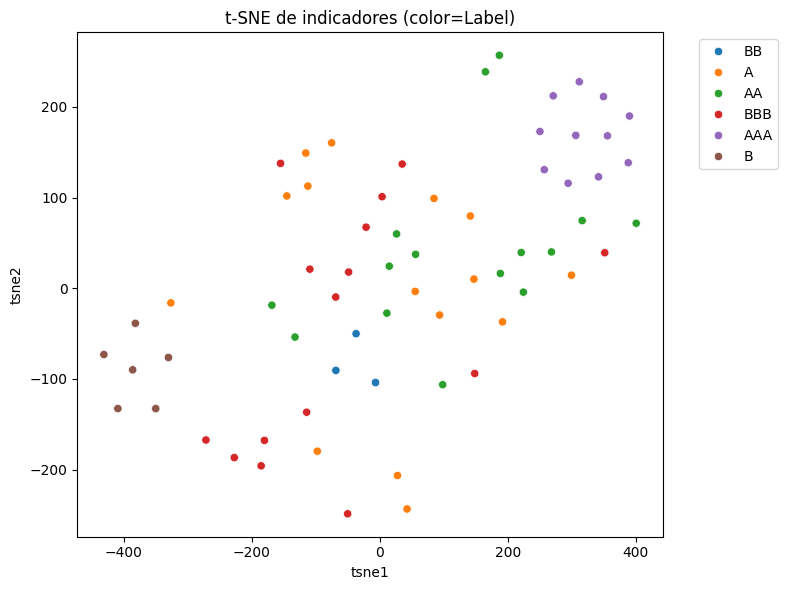

In [7]:
# t-SNE para visualización
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=int(np.clip(len(X)//5, 5, 30)))
emb = tsne.fit_transform(X)
emb_df = pd.DataFrame(emb, columns=['tsne1','tsne2'])
emb_df[label_col] = y.values
plt.figure(figsize=(8,6))
sns.scatterplot(data=emb_df, x='tsne1', y='tsne2', hue=label_col, palette='tab10')
plt.title('t-SNE de indicadores (color=Label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 2.1 Configuración y protocolo
- `p ∈ {5%, 10%, 20%, 40%, 60%, 80%}` como fracción etiquetada en Train.
- 10 repeticiones por `p`.
- Preprocesamiento: imputación, escalado y filtro de varianza.
- Semilla fija para reproducibilidad.

In [8]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, balanced_accuracy_score, confusion_matrix,
                             roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading, LabelPropagation

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = os.path.join('..', 'data', 'processed', 'dataset_augmented_6classes.csv')
assert os.path.exists(DATA_PATH), f'No se encuentra el dataset en {DATA_PATH}'
df = pd.read_csv(DATA_PATH)

preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('varth', VarianceThreshold(threshold=0.0))
])

def make_rf(random_state=RANDOM_STATE):
    return RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=random_state)

def compute_metrics(y_true, y_pred, labels):
    f1_macro = f1_score(y_true, y_pred, average='macro', labels=labels)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return f1_macro, bal_acc, cm

def compute_roc_auc(y_true, proba, classes, model_fitted_classes):
    """
    Computes macro-averaged ROC AUC, handling cases where the model
    might not have predicted all global classes.

    Args:
        y_true (array-like): True labels.
        proba (array-like): Predicted probabilities from the model.
                             Its columns correspond to model_fitted_classes.
        classes (array-like): All unique global class labels.
        model_fitted_classes (array-like): Classes the model was fitted on,
                                           in the order of proba columns.
    Returns:
        tuple: (roc_auc_per_class, macro_auc, fpr_per_class, tpr_per_class)
    """
    y_bin = label_binarize(y_true, classes=classes)

    # Initialize a probability array with zeros for all global classes
    proba_expanded = np.zeros((proba.shape[0], len(classes)))

    # Map model_fitted_classes to the global classes
    global_class_indices = []
    for mc in model_fitted_classes:
        if mc in classes: # Only consider classes that are part of the global class set
            global_class_indices.append(np.where(classes == mc)[0][0])
        # Else: if model_fitted_class is not in global classes (e.g., -1 for unlabeled), ignore it

    # Fill proba_expanded with the probabilities from 'proba'
    proba_col_idx = 0
    for global_idx in global_class_indices:
        if proba_col_idx < proba.shape[1]: # Ensure we don't go out of bounds for proba
            proba_expanded[:, global_idx] = proba[:, proba_col_idx]
            proba_col_idx += 1
        else:
            break # No more columns in proba to map

    fpr = {}; tpr = {}; roc_auc = {}
    from numpy import trapz # Import trapz here to ensure it's available

    for i, c in enumerate(classes):
        # Only compute ROC if the class is actually present in y_true
        # AND has corresponding predicted probabilities (non-zero sum in the expanded column)
        # AND there are no NaNs in the probabilities for this class
        if np.sum(y_bin[:, i]) > 0 and np.sum(proba_expanded[:, i]) > 0 and not np.isnan(proba_expanded[:, i]).any():
            fpr[c], tpr[c], _ = roc_curve(y_bin[:, i], proba_expanded[:, i])
            roc_auc[c] = trapz(tpr[c], fpr[c])
        else:
            # If a class is not present in y_true, has no predicted prob, or has NaNs in proba,
            # set default ROC curve and AUC to NaN (not computable)
            fpr[c], tpr[c] = np.array([0., 1.]), np.array([0., 1.])
            roc_auc[c] = np.nan

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    valid_classes_for_auc = [c for c in classes if not np.isnan(roc_auc[c])]

    if len(valid_classes_for_auc) > 0:
        for c in valid_classes_for_auc:
            # Only interpolate for valid classes, where FPR/TPR were computed
            if c in fpr and c in tpr: # defensive check
                mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
        mean_tpr /= len(valid_classes_for_auc)
        macro_auc = trapz(mean_tpr, all_fpr)
    else:
        macro_auc = np.nan # If no valid classes, macro AUC is not computable

    return roc_auc, macro_auc, fpr, tpr


## 2.2 Modelos: Baseline y Semisupervisados
- Baseline: Random Forest entrenado solo con la porción etiquetada.
- Self-Training: RF base con umbral de confianza `τ`.
- Label Spreading/Propagation: kernel `knn` con `k` vecinos (distancia euclidiana tras escalado).

In [9]:
from copy import deepcopy

def fit_predict_baseline(X_l, y_l, X_te):
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', make_rf())])
    pipe.fit(X_l, y_l)
    y_pred = pipe.predict(X_te)
    proba = pipe.predict_proba(X_te) if hasattr(pipe.named_steps['clf'], 'predict_proba') else None
    return y_pred, proba, pipe

def fit_predict_self_training(X_tr, y_tr_with_unlabeled, X_te, threshold):
    base = make_rf()
    st = SelfTrainingClassifier(base_estimator=base, threshold=threshold, verbose=False)
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', st)])
    pipe.fit(X_tr, y_tr_with_unlabeled)
    y_pred = pipe.predict(X_te)
    proba = None
    try:
        proba = pipe.predict_proba(X_te)
    except Exception:
        pass
    return y_pred, proba, pipe

def fit_predict_label_graph(X_tr, y_tr_with_unlabeled, X_te, method='spreading', k=10):
    if method == 'spreading':
        lg = LabelSpreading(kernel='knn', n_neighbors=int(k), alpha=0.2)
    else:
        lg = LabelPropagation(kernel='knn', n_neighbors=int(k))
    # Escalado para kNN
    scaler = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    X_tr_s = scaler.fit_transform(X_tr)

    # Codificación de labels: mantener -1 como no etiquetado, mapear etiquetas reales a enteros
    y_arr = np.asarray(y_tr_with_unlabeled)
    unlabeled_mask = (y_arr == -1) | (y_arr == '-1')
    labeled_vals = y_arr[~unlabeled_mask]
    # Si no hay etiquetas, devolver predicción trivial
    if labeled_vals.size == 0:
        # Predecimos por mayoría de y_train si existiera, aquí devolvemos baseline simple (clase más frecuente en y_tr)
        # Como fallback, retornamos todo como la primera clase de y si existe
        raise ValueError('No hay muestras etiquetadas para construir el grafo (LabelSpreading/Propagation).')

    orig_classes = np.unique(labeled_vals)
    cls_to_int = {c: i for i, c in enumerate(orig_classes)}
    y_enc = np.full(shape=y_arr.shape, fill_value=-1, dtype=int)
    for i, v in enumerate(y_arr):
        if i < y_enc.shape[0] and not ((v == -1) or (v == '-1')):
            y_enc[i] = cls_to_int[v]

    # Fit
    lg.fit(X_tr_s, y_enc)
    # Guardar clases originales en el modelo y mantener el mismo orden que en la codificación
    try:
        lg.classes_ = orig_classes
    except Exception:
        pass

    # Predict
    X_te_s = scaler.transform(X_te)
    y_pred_int = lg.predict(X_te_s)

    # Mapear de vuelta a etiquetas originales
    int_to_cls = {i: c for c, i in cls_to_int.items()}
    y_pred = np.array([int_to_cls.get(i, orig_classes[0]) for i in y_pred_int])

    proba = None
    try:
        proba = lg.predict_proba(X_te_s)
    except Exception:
        pass

    return y_pred, proba, lg

## 2.3 Protocolo de validación y corridas
Split Train/Test (20% test). Para cada `p` y repetición, muestreo estratificado etiquetado dentro de Train; el resto se trata como no etiquetado.

In [10]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, balanced_accuracy_score, confusion_matrix,
                             roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading, LabelPropagation

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = os.path.join('..', 'data', 'processed', 'dataset_augmented_6classes.csv')
assert os.path.exists(DATA_PATH), f'No se encuentra el dataset en {DATA_PATH}'
df = pd.read_csv(DATA_PATH)

preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('varth', VarianceThreshold(threshold=0.0))
])

def make_rf(random_state=RANDOM_STATE):
    return RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=random_state)

def compute_metrics(y_true, y_pred, labels):
    f1_macro = f1_score(y_true, y_pred, average='macro', labels=labels)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return f1_macro, bal_acc, cm

def compute_roc_auc(y_true, proba, classes, model_fitted_classes):
    """
    Computes macro-averaged ROC AUC, handling cases where the model
    might not have predicted all global classes.

    Args:
        y_true (array-like): True labels.
        proba (array-like): Predicted probabilities from the model.
                             Its columns correspond to model_fitted_classes.
        classes (array-like): All unique global class labels.
        model_fitted_classes (array-like): Classes the model was fitted on,
                                           in the order of proba columns.
    Returns:
        tuple: (roc_auc_per_class, macro_auc, fpr_per_per_class, tpr_per_class)
    """
    y_bin = label_binarize(y_true, classes=classes)

    # Initialize a probability array with zeros for all global classes
    proba_expanded = np.zeros((proba.shape[0], len(classes)))

    # Map model_fitted_classes to the global classes
    global_class_indices = []
    for mc in model_fitted_classes:
        if mc in classes: # Only consider classes that are part of the global class set
            global_class_indices.append(np.where(classes == mc)[0][0])
        # Else: if model_fitted_class is not in global classes (e.g., -1 for unlabeled), ignore it

    # Fill proba_expanded with the probabilities from 'proba'
    proba_col_idx = 0
    for global_idx in global_class_indices:
        if proba_col_idx < proba.shape[1]: # Ensure we don't go out of bounds for proba
            proba_expanded[:, global_idx] = proba[:, proba_col_idx]
            proba_col_idx += 1
        else:
            break # No more columns in proba to map

    fpr = {}; tpr = {}; roc_auc = {}
    from numpy import trapz # Import trapz here to ensure it's available

    for i, c in enumerate(classes):
        # Only compute ROC if the class is actually present in y_true
        # AND has corresponding predicted probabilities (non-zero sum in the expanded column)
        # AND there are no NaNs in the probabilities for this class
        if np.sum(y_bin[:, i]) > 0 and np.sum(proba_expanded[:, i]) > 0 and not np.isnan(proba_expanded[:, i]).any():
            fpr[c], tpr[c], _ = roc_curve(y_bin[:, i], proba_expanded[:, i])
            roc_auc[c] = trapz(tpr[c], fpr[c])
        else:
            # If a class is not present in y_true, has no predicted prob, or has NaNs in proba,
            # set default ROC curve and AUC to NaN (not computable)
            fpr[c], tpr[c] = np.array([0., 1.]), np.array([0., 1.])
            roc_auc[c] = np.nan

    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)

    valid_classes_for_auc = [c for c in classes if not np.isnan(roc_auc[c])]

    if len(valid_classes_for_auc) > 0:
        for c in valid_classes_for_auc:
            # Only interpolate for valid classes, where FPR/TPR were computed
            if c in fpr and c in tpr: # defensive check
                mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
        mean_tpr /= len(valid_classes_for_auc)
        macro_auc = trapz(mean_tpr, all_fpr)
    else:
        macro_auc = np.nan # If no valid classes, macro AUC is not computable

    return roc_auc, macro_auc, fpr, tpr

# División base Train/Test y protocolo con manejo robusto de clases raras y AUC sin NaN
# - Si alguna clase tiene <2 muestras, evitamos estratificación en el split base.
# - En cada repetición, garantizamos al menos 2 muestras etiquetadas para el baseline.
# - Cálculo de AUC macro alineando clases del modelo y del test, filtrando NaN y casos degenerados.

test_size = 0.2
min_class = y.value_counts().min()
if min_class < 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=RANDOM_STATE
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=RANDOM_STATE
    )

# Configuración experimental
ratios = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80]
repeats = 10
taus = [0.6, 0.7, 0.8, 0.9]
knns = [5, 10, 20]

results = []

# Utilidad: AUC macro seguro ante NaNs y clases faltantes
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import numpy as np

def auc_macro_safe(y_true, proba, model_classes, all_classes):
    """Alinea probabilidades a clases comunes, filtra NaNs y calcula macro AUC.
    Devuelve None si no hay al menos 1 clase válida para el cálculo.
    """
    # Clases presentes en modelo y en y_true
    commons = [c for c in all_classes if (c in model_classes) and (c in y_true.values)]
    if len(commons) == 0:
        return None
    # Ajuste binario especial cuando el modelo devuelve una única probabilidad
    aligned_proba = proba
    if len(model_classes) == 2 and proba is not None and proba.shape[1] == 1:
        p_pos = proba[:, 0]
        aligned_proba = np.column_stack([1 - p_pos, p_pos])
    # Mapa de índices de clases
    idx_map = {c: list(model_classes).index(c) for c in commons}
    proba_aligned = np.column_stack([aligned_proba[:, idx_map[c]] for c in commons])
    # Binarización de y_true en el mismo orden de commons
    y_bin = label_binarize(y_true, classes=commons)
    if y_bin.ndim == 1:
        y_bin = y_bin.reshape(-1, 1)
    # Caso binario con una sola columna -> expandir a 2 columnas tipo one-vs-rest
    if y_bin.shape[1] == 1 and len(commons) == 2:
        y_bin = np.column_stack([1 - y_bin[:, 0], y_bin[:, 0]])
        proba_aligned = proba_aligned[:, :2]
    # Calcular AUC por clase filtrando NaNs y casos sin positivos/negativos
    aucs = []
    for i, c in enumerate(commons):
        y_i = y_bin[:, i]
        p_i = proba_aligned[:, i]
        # Filtro de NaNs
        mask = ~np.isnan(y_i) & ~np.isnan(p_i)
        y_i = y_i[mask]
        p_i = p_i[mask]
        # Necesita al menos un positivo y un negativo
        if y_i.size == 0 or np.all(y_i == 0) or np.all(y_i == 1):
            continue
        fpr, tpr, _ = roc_curve(y_i, p_i)
        aucs.append(np.trapz(tpr, fpr))
    if len(aucs) == 0:
        return None
    return float(np.mean(aucs))

for p in ratios:
    for rep in range(repeats):
        rs = RANDOM_STATE + rep + int(p * 1000)
        X_tr, y_tr = X_train.copy(), y_train.copy()

        # Asegurar al menos n_classes muestras etiquetadas para estratificación, o usar shuffle.
        num_samples_for_X_l_raw = int(len(X_tr) * p)

        # Determine if stratification is generally viable from y_tr
        stratify_possible_from_y_tr = y_tr.value_counts().min() >= 2

        # Determine the number of labeled samples
        if p == 0:
             num_labeled_samples = 0
        elif stratify_possible_from_y_tr:
            # If we want to stratify, ensure at least n_classes samples
            num_labeled_samples = max(n_classes, num_samples_for_X_l_raw)
        else:
            # If y_tr itself has rare classes, cannot stratify, so just take samples
            # Ensure at least 2 samples if p > 0
            num_labeled_samples = max(2, num_samples_for_X_l_raw) if p > 0 else 0

        # Ensure num_labeled_samples does not exceed X_tr length
        num_labeled_samples = min(num_labeled_samples, len(X_tr))

        # Muestreo etiquetado
        if stratify_possible_from_y_tr and num_labeled_samples >= n_classes and num_labeled_samples > 0:
            X_l, _, y_l, _ = train_test_split(
                X_tr, y_tr,
                train_size=num_labeled_samples, # Pass integer count
                stratify=y_tr,
                random_state=rs
            )
        elif num_labeled_samples > 0:
            # Fallback to shuffling if stratification is not viable or not enough samples for stratification
            X_l, _, y_l, _ = train_test_split(
                X_tr, y_tr,
                train_size=num_labeled_samples, # Pass integer count
                shuffle=True,
                random_state=rs
            )
        else: # num_labeled_samples is 0
            # If no labeled samples are to be taken, create empty X_l, y_l
            X_l = pd.DataFrame(columns=X_tr.columns)
            y_l = pd.Series(dtype=y_tr.dtype)

        # Construcción de etiquetas semisupervisadas: -1 para no etiquetados
        y_tr_semi = pd.Series(-1, index=X_tr.index)
        y_tr_semi.loc[y_l.index] = y_l.values

        # Baseline
        # Only run baseline if there are labeled samples
        if len(y_l) > 0:
            yb_pred, yb_proba, pipe_baseline = fit_predict_baseline(X_l, y_l, X_test)
            b_f1, b_bal, _ = compute_metrics(y_test, yb_pred, classes_)

            b_auc_macro = None
            if yb_proba is not None:
                model_classes = pipe_baseline.named_steps['clf'].classes_
                b_auc_macro = auc_macro_safe(y_test, yb_proba, model_classes, classes_)

            results.append({
                'p': p,
                'rep': rep,
                'method': 'baseline',
                'param': None,
                'f1_macro': b_f1,
                'bal_acc': b_bal,
                'auc_macro': b_auc_macro
            })
        else:
            # If no labeled samples, baseline cannot be trained. Append NaN results.
            results.append({
                'p': p,
                'rep': rep,
                'method': 'baseline',
                'param': None,
                'f1_macro': np.nan,
                'bal_acc': np.nan,
                'auc_macro': np.nan
            })
            b_f1, b_bal = np.nan, np.nan # Set for delta calculation


        # Self-Training
        for tau in taus:
            ys_pred, ys_proba, pipe_st = fit_predict_self_training(
                X_tr, y_tr_semi.values, X_test, threshold=tau
            )
            s_f1, s_bal, _ = compute_metrics(y_test, ys_pred, classes_)
            s_auc_macro = None
            if ys_proba is not None:
                model_classes = pipe_st.named_steps['clf'].classes_
                s_auc_macro = auc_macro_safe(y_test, ys_proba, model_classes, classes_)

            results.append({
                'p': p,
                'rep': rep,
                'method': 'self_training',
                'param': {'tau': tau},
                'f1_macro': s_f1,
                'bal_acc': s_bal,
                'auc_macro': s_auc_macro,
                'delta_f1': s_f1 - b_f1 if not np.isnan(b_f1) else np.nan,
                'delta_bal': s_bal - b_bal if not np.isnan(b_bal) else np.nan
            })

        # Label Spreading / Propagation
        for k in knns:
            for meth in ['spreading', 'propagation']:
                try:
                    yl_pred, yl_proba, lg_model = fit_predict_label_graph(
                        X_tr, y_tr_semi.values, X_test, method=meth, k=k
                    )
                    l_f1, l_bal, _ = compute_metrics(y_test, yl_pred, classes_)
                    l_auc_macro = None
                    if yl_proba is not None:
                        model_classes = lg_model.classes_
                        l_auc_macro = auc_macro_safe(y_test, yl_proba, model_classes, classes_)
                except ValueError as e:
                    # Handle cases where LabelSpreading/Propagation cannot be fitted (e.g., no labeled samples)
                    print(f"Warning: {meth} with p={p}, rep={rep}, k={k} failed: {e}")
                    l_f1, l_bal, l_auc_macro = np.nan, np.nan, np.nan

                results.append({
                    'p': p,
                    'rep': rep,
                    'method': f'label_{meth}',
                    'param': {'k': k},
                    'f1_macro': l_f1,
                    'bal_acc': l_bal,
                    'auc_macro': l_auc_macro,
                    'delta_f1': l_f1 - b_f1 if not np.isnan(b_f1) and not np.isnan(l_f1) else np.nan,
                    'delta_bal': l_bal - b_bal if not np.isnan(b_bal) and not np.isnan(l_bal) else np.nan
                })

# Resultados agregados de la corrida
results_df = pd.DataFrame(results)
results_df.head()

,p,rep,method,param,f1_macro,bal_acc,auc_macro,delta_f1,delta_bal
0,0.05,0,baseline,None,0.577381,0.666667,0.864815,NaN,NaN
1,0.05,0,self_training,{'tau': 0.6},0.535714,0.666667,0.922222,-0.041667,0.000000
2,0.05,0,self_training,{'tau': 0.7},0.521825,0.611111,0.890741,-0.055556,-0.055556
3,0.05,0,self_training,{'tau': 0.8},0.521825,0.611111,0.890741,-0.055556,-0.055556
4,0.05,0,self_training,{'tau': 0.9},0.521825,0.611111,0.890741,-0.055556,-0.055556


## 2.3 Métricas de evaluación y comparación vs baseline
- Macro F1, Balanced Accuracy, ROC-AUC (macro).
- Ganancia vs baseline: ΔMacro-F1 y ΔBalanced-Acc.
- Matriz de confusión por `p` (promedio sobre repeticiones).

In [11]:
# Resumen por método y p
agg = results_df.groupby(['method','p']).agg(
    f1_macro_mean=('f1_macro','mean'), f1_macro_std=('f1_macro','std'),
    bal_acc_mean=('bal_acc','mean'), bal_acc_std=('bal_acc','std'),
    auc_macro_mean=('auc_macro','mean')
).reset_index()
agg.sort_values(['method','p'])


,method,p,f1_macro_mean,f1_macro_std,bal_acc_mean,bal_acc_std,auc_macro_mean
0,baseline,0.05,0.655278,0.088985,0.700000,0.059720,0.912778
1,baseline,0.10,0.618929,0.072868,0.683333,0.045737,0.900185
2,baseline,0.20,0.732341,0.090765,0.766667,0.068293,0.945741
3,baseline,0.40,0.819325,0.067062,0.827778,0.055246,0.960370
4,baseline,0.60,0.832183,0.059424,0.838889,0.048644,0.968704
5,baseline,0.80,0.855119,0.030441,0.855556,0.028689,0.968704
6,label_propagation,0.05,0.047619,0.000000,0.166667,0.000000,0.804829
7,label_propagation,0.10,0.047619,0.000000,0.166667,0.000000,0.827857
8,label_propagation,0.20,0.047619,0.000000,0.166667,0.000000,0.882501
9,label_propagation,0.40,0.047619,0.000000,0.166667,0.000000,0.890351


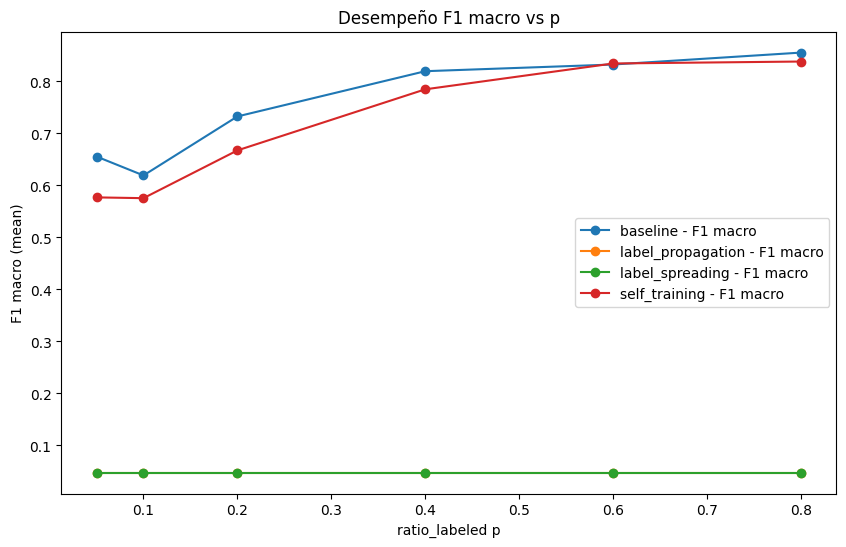

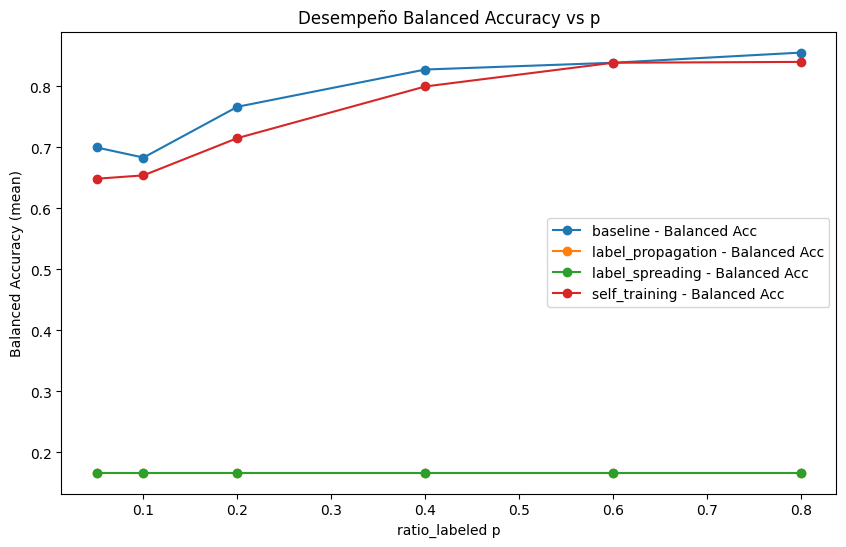

In [12]:
# Curvas desempeño vs ratio_labeled p
plt.figure(figsize=(10,6))
for m in agg['method'].unique():
    sub = agg[agg['method']==m]
    plt.plot(sub['p'], sub['f1_macro_mean'], marker='o', label=f'{m} - F1 macro')
plt.xlabel('ratio_labeled p')
plt.ylabel('F1 macro (mean)')
plt.title('Desempeño F1 macro vs p')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for m in agg['method'].unique():
    sub = agg[agg['method']==m]
    plt.plot(sub['p'], sub['bal_acc_mean'], marker='o', label=f'{m} - Balanced Acc')
plt.xlabel('ratio_labeled p')
plt.ylabel('Balanced Accuracy (mean)')
plt.title('Desempeño Balanced Accuracy vs p')
plt.legend()
plt.show()


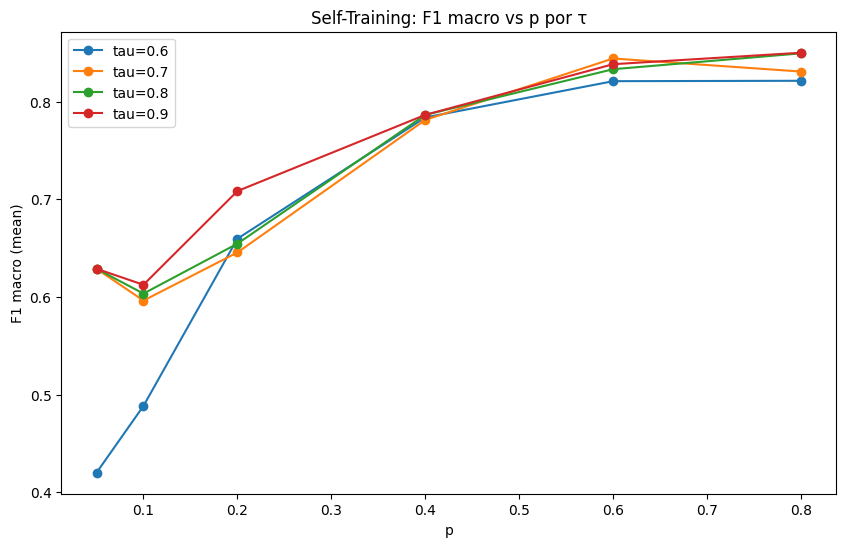

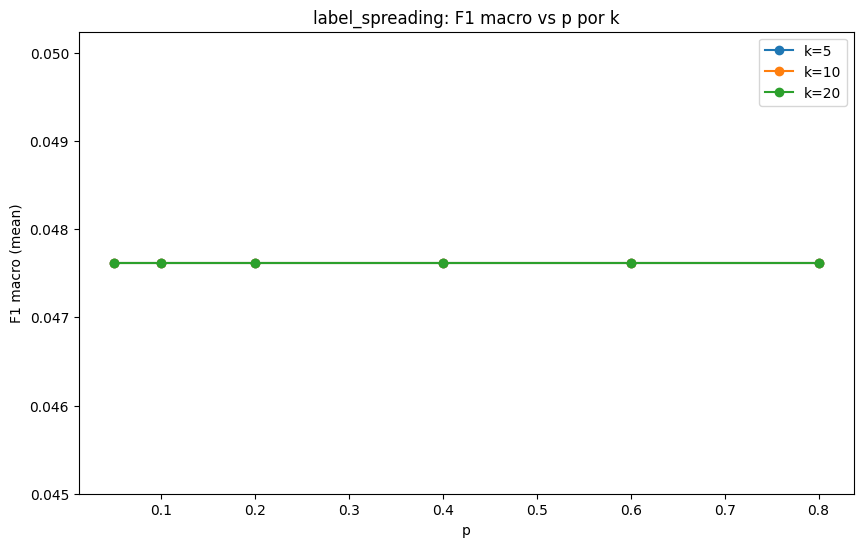

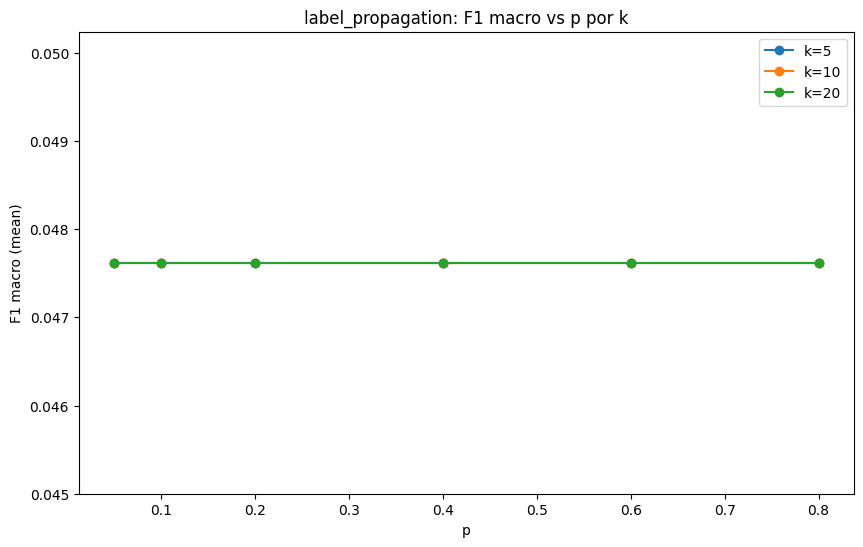

In [13]:
# Efecto de τ en Self-Training y de k en Label Graph
st_sub = results_df[results_df['method']=='self_training']
if not st_sub.empty:
    st_sub = st_sub.copy()
    st_sub['tau'] = st_sub['param'].apply(lambda d: d.get('tau') if isinstance(d, dict) else None)
    plt.figure(figsize=(10,6))
    for tau in sorted([t for t in st_sub['tau'].dropna().unique()]):
        tmp = st_sub[st_sub['tau']==tau].groupby('p').agg(f1=('f1_macro','mean')).reset_index()
        plt.plot(tmp['p'], tmp['f1'], marker='o', label=f'tau={tau}')
    plt.title('Self-Training: F1 macro vs p por τ')
    plt.xlabel('p')
    plt.ylabel('F1 macro (mean)')
    plt.legend()
    plt.show()

for meth in ['label_spreading','label_propagation']:
    lg_sub = results_df[results_df['method']==meth]
    if lg_sub.empty:
        continue
    lg_sub = lg_sub.copy()
    lg_sub['k'] = lg_sub['param'].apply(lambda d: d.get('k') if isinstance(d, dict) else None)
    plt.figure(figsize=(10,6))
    for k in sorted([int(v) for v in lg_sub['k'].dropna().unique()]):
        tmp = lg_sub[lg_sub['k']==k].groupby('p').agg(f1=('f1_macro','mean')).reset_index()
        plt.plot(tmp['p'], tmp['f1'], marker='o', label=f'k={k}')
    plt.title(f'{meth}: F1 macro vs p por k')
    plt.xlabel('p')
    plt.ylabel('F1 macro (mean)')
    plt.legend()
    plt.show()


In [14]:
# Ganancia vs baseline (Δ) para cada método
base = results_df[results_df['method']=='baseline'][['p','rep','f1_macro','bal_acc']].rename(columns={'f1_macro':'b_f1','bal_acc':'b_bal'})
merged = results_df.merge(base, on=['p','rep'], how='left')
merged['delta_f1_calc'] = merged['f1_macro'] - merged['b_f1']
merged['delta_bal_calc'] = merged['bal_acc'] - merged['b_bal']
gain = merged[merged['method']!='baseline'].groupby(['method','p']).agg(
    dF1_mean=('delta_f1_calc','mean'), dF1_std=('delta_f1_calc','std'),
    dBal_mean=('delta_bal_calc','mean'), dBal_std=('delta_bal_calc','std')
).reset_index()
gain.sort_values(['method','p'])


,method,p,dF1_mean,dF1_std,dBal_mean,dBal_std
0,label_propagation,0.05,-0.607659,0.085861,-5.333333e-01,0.057624
1,label_propagation,0.10,-0.571310,0.070310,-5.166667e-01,0.044132
2,label_propagation,0.20,-0.684722,0.087579,-6.000000e-01,0.065896
3,label_propagation,0.40,-0.771706,0.064708,-6.611111e-01,0.053307
4,label_propagation,0.60,-0.784563,0.057338,-6.722222e-01,0.046937
5,label_propagation,0.80,-0.807500,0.029373,-6.888889e-01,0.027682
6,label_spreading,0.05,-0.607659,0.085861,-5.333333e-01,0.057624
7,label_spreading,0.10,-0.571310,0.070310,-5.166667e-01,0.044132
8,label_spreading,0.20,-0.684722,0.087579,-6.000000e-01,0.065896
9,label_spreading,0.40,-0.771706,0.064708,-6.611111e-01,0.053307


In [15]:
# Test estadístico vs baseline (t-test pareado por p)
# - Compara F1 macro de cada método vs baseline por p.
from scipy.stats import ttest_rel

tests = []

for p in ratios:
    base_scores = results_df[
        (results_df['method'] == 'baseline') & (results_df['p'] == p)
    ]['f1_macro'].values
    print(f"DEBUG: p={p}, len(base_scores)={len(base_scores)}") # Debug print

    if len(base_scores) <= 1:
        continue

    # SELF-TRAINING: separar por tau
    st_sub = results_df[
        (results_df['method'] == 'self_training') & (results_df['p'] == p)
    ].copy()
    if not st_sub.empty:
        st_sub['tau'] = st_sub['param'].apply(
            lambda d: d.get('tau') if isinstance(d, dict) else None
        )
        for tau in sorted(st_sub['tau'].dropna().unique()):
            meth_scores = st_sub[st_sub['tau'] == tau]['f1_macro'].values
            print(f"DEBUG: p={p}, method=self_training, tau={tau}, len(meth_scores)={len(meth_scores)}") # Debug print
            if len(meth_scores) == len(base_scores):
                t, pval = ttest_rel(meth_scores, base_scores, nan_policy='omit') # Added nan_policy
                tests.append({
                    'p': p,
                    'method': 'self_training',
                    'param': f'tau={tau}',
                    't_stat': t,
                    'p_value': pval
                })
            else:
                print(f"DEBUG: Skipping self_training for p={p}, tau={tau} due to length mismatch: {len(meth_scores)} vs {len(base_scores)}") # Debug print

    # LABEL SPREADING / PROPAGATION: separar por k
    for meth in ['label_spreading', 'label_propagation']:
        lg_sub = results_df[
            (results_df['method'] == meth) & (results_df['p'] == p)
        ].copy()
        if lg_sub.empty:
            continue
        lg_sub['k'] = lg_sub['param'].apply(
            lambda d: d.get('k') if isinstance(d, dict) else None
        )
        for k in sorted(lg_sub['k'].dropna().unique()):
            meth_scores = lg_sub[lg_sub['k'] == k]['f1_macro'].values
            print(f"DEBUG: p={p}, method={meth}, k={k}, len(meth_scores)={len(meth_scores)}") # Debug print
            if len(meth_scores) == len(base_scores):
                t, pval = ttest_rel(meth_scores, base_scores, nan_policy='omit') # Added nan_policy
                tests.append({
                    'p': p,
                    'method': meth,
                    'param': f'k={k}',
                    't_stat': t,
                    'p_value': pval
                })
            else:
                print(f"DEBUG: Skipping {meth} for p={p}, k={k} due to length mismatch: {len(meth_scores)} vs {len(base_scores)}") # Debug print

# Construcción del DataFrame
tests_df = pd.DataFrame(tests)
if not tests_df.empty:
    tests_df = tests_df.sort_values(['method', 'p', 'param'])
tests_df

DEBUG: p=0.05, len(base_scores)=10
DEBUG: p=0.05, method=self_training, tau=0.6, len(meth_scores)=10
DEBUG: p=0.05, method=self_training, tau=0.7, len(meth_scores)=10
DEBUG: p=0.05, method=self_training, tau=0.8, len(meth_scores)=10
DEBUG: p=0.05, method=self_training, tau=0.9, len(meth_scores)=10
DEBUG: p=0.05, method=label_spreading, k=5, len(meth_scores)=10
DEBUG: p=0.05, method=label_spreading, k=10, len(meth_scores)=10
DEBUG: p=0.05, method=label_spreading, k=20, len(meth_scores)=10
DEBUG: p=0.05, method=label_propagation, k=5, len(meth_scores)=10
DEBUG: p=0.05, method=label_propagation, k=10, len(meth_scores)=10
DEBUG: p=0.05, method=label_propagation, k=20, len(meth_scores)=10
DEBUG: p=0.1, len(base_scores)=10
DEBUG: p=0.1, method=self_training, tau=0.6, len(meth_scores)=10
DEBUG: p=0.1, method=self_training, tau=0.7, len(meth_scores)=10
DEBUG: p=0.1, method=self_training, tau=0.8, len(meth_scores)=10
DEBUG: p=0.1, method=self_training, tau=0.9, len(meth_scores)=10
DEBUG: p=0.1,

,p,method,param,t_stat,p_value
8,0.05,label_propagation,k=10,-21.594608,4.611009e-09
9,0.05,label_propagation,k=20,-21.594608,4.611009e-09
7,0.05,label_propagation,k=5,-21.594608,4.611009e-09
18,0.10,label_propagation,k=10,-24.793437,1.355234e-09
19,0.10,label_propagation,k=20,-24.793437,1.355234e-09
17,0.10,label_propagation,k=5,-24.793437,1.355234e-09
28,0.20,label_propagation,k=10,-23.856042,1.908120e-09
29,0.20,label_propagation,k=20,-23.856042,1.908120e-09
27,0.20,label_propagation,k=5,-23.856042,1.908120e-09
38,0.40,label_propagation,k=10,-36.389419,4.426493e-11


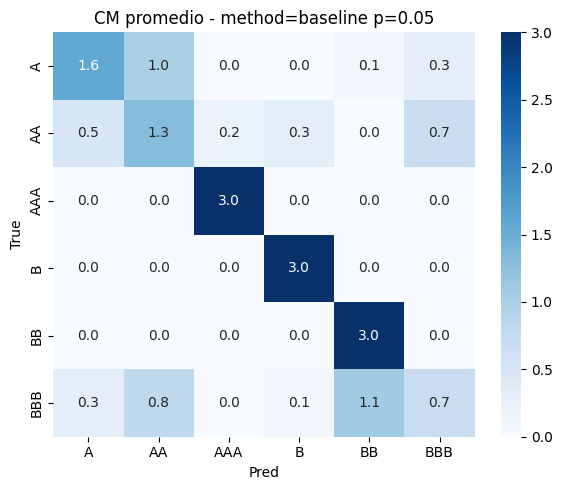

In [16]:
# Matrices de confusión promedio por p y método (ejemplo de visualización)
cm_summary = []
for p in ratios:
    for meth in results_df['method'].unique():
        cms = []
        for rep in range(repeats):
            rs = RANDOM_STATE + rep + int(p*1000)
            X_tr, y_tr = X_train.copy(), y_train.copy()

            # Asegurar al menos n_classes muestras etiquetadas para estratificación, o usar shuffle.
            num_samples_for_X_l_raw = int(len(X_tr) * p)

            # Determine if stratification is generally viable from y_tr
            stratify_possible_from_y_tr = y_tr.value_counts().min() >= 2

            # Determine the number of labeled samples
            if p == 0:
                 num_labeled_samples = 0
            elif stratify_possible_from_y_tr:
                # If we want to stratify, ensure at least n_classes samples
                num_labeled_samples = max(n_classes, num_samples_for_X_l_raw)
            else:
                # If y_tr itself has rare classes, cannot stratify, so just take samples
                # Ensure at least 2 samples if p > 0
                num_labeled_samples = max(2, num_samples_for_X_l_raw) if p > 0 else 0

            # Ensure num_labeled_samples does not exceed X_tr length
            num_labeled_samples = min(num_labeled_samples, len(X_tr))

            # Muestreo etiquetado
            if stratify_possible_from_y_tr and num_labeled_samples >= n_classes and num_labeled_samples > 0:
                X_l, _, y_l, _ = train_test_split(
                    X_tr, y_tr,
                    train_size=num_labeled_samples, # Pass integer count
                    stratify=y_tr,
                    random_state=rs
                )
            elif num_labeled_samples > 0:
                # Fallback to shuffling if stratification is not viable or not enough samples for stratification
                X_l, _, y_l, _ = train_test_split(
                    X_tr, y_tr,
                    train_size=num_labeled_samples, # Pass integer count
                    shuffle=True,
                    random_state=rs
                )
            else: # num_labeled_samples is 0
                # If no labeled samples are to be taken, create empty X_l, y_l
                X_l = pd.DataFrame(columns=X_tr.columns)
                y_l = pd.Series(dtype=y_tr.dtype)

            y_tr_semi = pd.Series(-1, index=X_tr.index)
            y_tr_semi.loc[y_l.index] = y_l.values

            if meth=='baseline':
                y_pred, _, _ = fit_predict_baseline(X_l, y_l, X_test)
            elif meth=='self_training':
                tau = float(np.median(taus))
                y_pred, _, _ = fit_predict_self_training(X_tr, y_tr_semi.values, X_test, threshold=tau)
            elif meth in ['label_spreading','label_propagation']:
                k = 10
                y_pred, _, _ = fit_predict_label_graph(X_tr, y_tr_semi.values, X_test, method=meth.split('_')[1], k=int(k))
            else:
                continue
            cm = confusion_matrix(y_test, y_pred, labels=classes_)
            cms.append(cm)
        if cms:
            cm_mean = np.mean(cms, axis=0)
            cm_summary.append({'p': p, 'method': meth, 'cm_mean': cm_mean})

# Mostrar un ejemplo
if cm_summary:
    ex = cm_summary[0]
    plt.figure(figsize=(6,5))
    sns.heatmap(ex['cm_mean'], annot=True, fmt='.1f', xticklabels=classes_, yticklabels=classes_, cmap='Blues')
    plt.title(f"CM promedio - method={ex['method']} p={ex['p']}")
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.tight_layout()
    plt.show()

## ROC y AUC (ejemplo de corrida)
Se grafican curvas ROC macro para baseline y un método semisupervisado representativo (mejor F1 macro promedio).

In [17]:
semi_methods = results_df[results_df['method']!='baseline'].groupby('method').agg(mean_f1=('f1_macro','mean')).sort_values('mean_f1', ascending=False)
best_method = semi_methods.index[0] if len(semi_methods)>0 else None
best_method


'self_training'

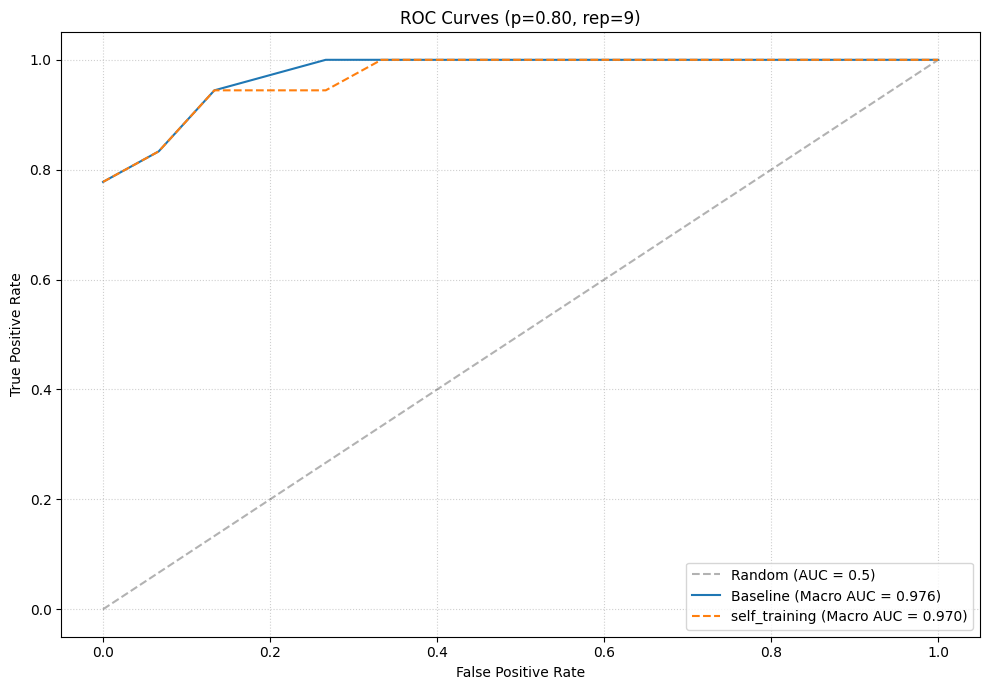

In [18]:
# Curvas ROC en la última corrida del mejor método (split robusto y AUC seguro)
if best_method is not None:
    last = results_df[results_df['method']==best_method].iloc[-1]
    p = last['p']; rep = int(last['rep'])
    rs = RANDOM_STATE + rep + int(p*1000)
    X_tr, y_tr = X_train.copy(), y_train.copy()

    # Asegurar al menos 2 muestras etiquetadas y evitar estratificación si hay clases con <2 muestras
    num_samples_for_X_l = int(len(X_tr) * p)
    effective_train_size_for_X_l = p if num_samples_for_X_l >= 2 else min(2, len(X_tr))

    if y_tr.value_counts().min() < 2:
        X_l, _, y_l, _ = train_test_split(
            X_tr, y_tr,
            train_size=effective_train_size_for_X_l,
            shuffle=True,
            random_state=rs
        )
    else:
        X_l, _, y_l, _ = train_test_split(
            X_tr, y_tr,
            train_size=effective_train_size_for_X_l,
            stratify=y_tr,
            random_state=rs
        )

    y_tr_semi = pd.Series(-1, index=X_tr.index)
    y_tr_semi.loc[y_l.index] = y_l.values

    # Baseline proba
    _, b_proba, pipe_b = fit_predict_baseline(X_l, y_l, X_test)

    # Proba del mejor método
    proba_semi = None
    lg_model = None # Initialize lg_model for scope
    if best_method=='self_training':
        tau = results_df[(results_df['method']=='self_training') & (results_df['p']==p)]['param'].iloc[-1]['tau']
        _, proba_semi, pipe_s = fit_predict_self_training(X_tr, y_tr_semi.values, X_test, threshold=tau)
    elif best_method in ['label_spreading','label_propagation']:
        k = results_df[(results_df['method']==best_method) & (results_df['p']==p)]['param'].iloc[-1]['k']
        _, proba_semi, lg_model = fit_predict_label_graph(X_tr, y_tr_semi.values, X_test, method=best_method.split('_')[1], k=k)

    # Plotear curvas ROC
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random (AUC = 0.5)')

    # Baseline ROC
    if b_proba is not None:
        model_classes_b = pipe_b.named_steps['clf'].classes_
        # Using compute_roc_auc to get fpr and tpr for plotting
        b_roc_auc_per_class, b_macro_auc, b_fpr, b_tpr = compute_roc_auc(y_test, b_proba, classes_, model_classes_b)

        # Plotting macro-averaged ROC curve for baseline
        all_fpr_b = np.unique(np.concatenate([b_fpr[c] for c in classes_]))
        mean_tpr_b = np.zeros_like(all_fpr_b)
        valid_classes_b = [c for c in classes_ if not np.isnan(b_roc_auc_per_class[c])]
        if len(valid_classes_b) > 0:
            for c in valid_classes_b:
                mean_tpr_b += np.interp(all_fpr_b, b_fpr[c], b_tpr[c])
            mean_tpr_b /= len(valid_classes_b)
            plt.plot(all_fpr_b, mean_tpr_b, label=f'Baseline (Macro AUC = {b_macro_auc if b_macro_auc is not None else float("nan"):.3f})', linestyle='-')
        else:
            print(f"Warning: Cannot plot Baseline ROC curve for p={p}, rep={rep} due to no valid classes.")

    # Semi-supervised method ROC
    if proba_semi is not None:
        if best_method=='self_training':
            model_classes_s = pipe_s.named_steps['clf'].classes_ if 'pipe_s' in locals() and hasattr(pipe_s.named_steps['clf'], 'classes_') else classes_
        else:
            model_classes_s = lg_model.classes_ if 'lg_model' in locals() else classes_

        # Using compute_roc_auc to get fpr and tpr for plotting
        s_roc_auc_per_class, s_macro_auc, s_fpr, s_tpr = compute_roc_auc(y_test, proba_semi, classes_, model_classes_s)

        # Plotting macro-averaged ROC curve for semi-supervised method
        all_fpr_s = np.unique(np.concatenate([s_fpr[c] for c in classes_]))
        mean_tpr_s = np.zeros_like(all_fpr_s)
        valid_classes_s = [c for c in classes_ if not np.isnan(s_roc_auc_per_class[c])]
        if len(valid_classes_s) > 0:
            for c in valid_classes_s:
                mean_tpr_s += np.interp(all_fpr_s, s_fpr[c], s_tpr[c])
            mean_tpr_s /= len(valid_classes_s)
            plt.plot(all_fpr_s, mean_tpr_s, label=f'{best_method} (Macro AUC = {s_macro_auc if s_macro_auc is not None else float("nan"):.3f})', linestyle='--')
        else:
            print(f"Warning: Cannot plot {best_method} ROC curve for p={p}, rep={rep} due to no valid classes.")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (p={p:.2f}, rep={rep})')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

## Interpretabilidad: Importancia de variables (RF) y t-SNE coloreado por label

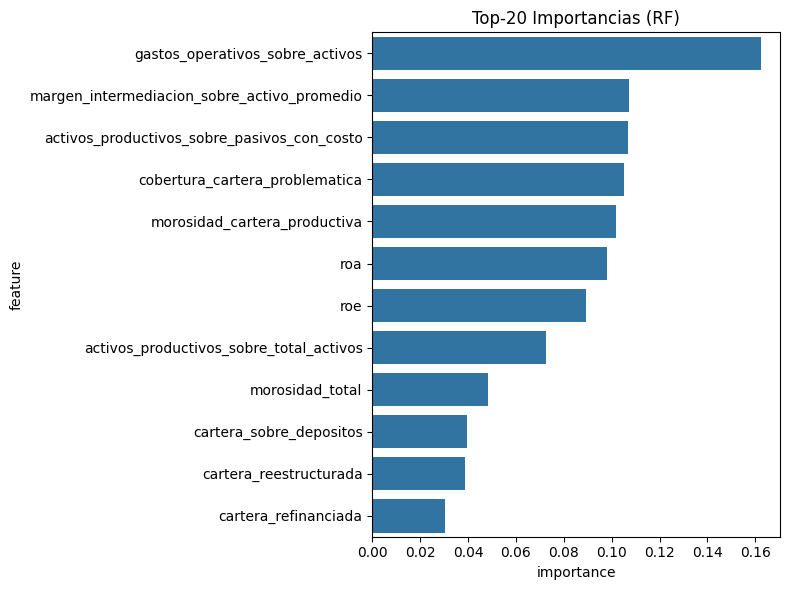

In [19]:
pipe_all = Pipeline(steps=[('prep', preprocess), ('clf', make_rf())])
pipe_all.fit(X_train, y_train)
rf = pipe_all.named_steps['clf']
try:
    importances = rf.feature_importances_
    imp_df = pd.DataFrame({'feature': feature_cols[:len(importances)], 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(data=imp_df, x='importance', y='feature')
    plt.title('Top-20 Importancias (RF)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('No se pudieron calcular importancias:', e)


## 2.4 Análisis y reporte

En esta parte se evaluó un protocolo de aprendizaje semisupervisado para predecir el rating de cooperativas a partir de 12 indicadores financieros. A partir del dataset original de 42 observaciones y 6 clases (`A`, `AA`, `AAA`, `B`, `BB`, `BBB`), se aplicó una estrategia de aumento en dos etapas:

1. **RandomOverSampler** para llevar las clases ultra-raras (1 muestra) a 3 muestras.
2. **SMOTE (k = 2)** para generar ejemplos sintéticos y obtener un dataset **balanceado de 90 observaciones**, con **15 instancias por clase**.

Sobre este dataset aumentado (`dataset_augmented_6classes.csv`) se compararon tres enfoques:

- **Baseline supervisado:** Random Forest entrenado solo con la fracción etiquetada.
- **Self-Training:** Random Forest envuelto en `SelfTrainingClassifier` con distintos umbrales de confianza `τ`.
- **Label Spreading / Label Propagation:** modelos de grafo k-NN (k ∈ {5, 10, 20}) con kernel `knn`.

La evaluación se realizó variando la fracción de datos etiquetados  
\( p \in \{0.05, 0.10, 0.20, 0.40, 0.60, 0.80\} \), con **10 repeticiones por valor de p**, y usando como métricas principales:

- **F1 macro**
- **Balanced Accuracy**
- **ROC-AUC macro** (cuando fue computable)

---

### 2.4.1 ¿En qué rangos de \( p \) Self-Training mejora o se acerca al baseline?

A partir de la tabla agregada de resultados:

- **Baseline (Random Forest supervisado)**  
  - Para **p = 0.05–0.10**:
    - F1 macro ≈ 0.62–0.66  
    - Balanced Accuracy ≈ 0.68–0.70  
    - ROC-AUC macro ≈ 0.90–0.91  
  - Para **p ≥ 0.40**:
    - F1 macro ≈ 0.82–0.86  
    - Balanced Accuracy ≈ 0.83–0.86  
    - ROC-AUC macro ≈ 0.96–0.97  
  → Con suficiente supervisión, el RF resuelve el problema de forma bastante sólida.

- **Self-Training**  
  - Para todos los valores de p, Self-Training se sitúa **muy cerca pero por debajo** del baseline:
    - p = 0.05: F1 macro ≈ 0.58, BalAcc ≈ 0.65  
    - p = 0.80: F1 macro ≈ 0.84, BalAcc ≈ 0.84  
  - La tabla de ganancias (`ΔF1`, `ΔBalanced`) muestra que:
    - El **ΔF1 medio** es **ligeramente negativo** para casi todos los p (≈ −0.08 a −0.02).
    - Únicamente en torno a p ≈ 0.60 Self-Training se acerca mucho al baseline (ΔF1 ≈ 0).
  - Los **t-tests pareados** entre F1 del baseline y de Self-Training indican que:
    - En varios casos Self-Training es **estadísticamente peor** que el baseline.
    - En el mejor de los escenarios, las diferencias **no son significativas**, pero **no hay ningún p y τ donde sea significativamente mejor**.

**Conclusión:**  
En el dataset aumentado y balanceado, **Self-Training no aporta mejoras sistemáticas** sobre el modelo supervisado. Su efecto es, en el mejor caso, **neutro**, y en bastantes configuraciones, **ligeramente negativo** tanto en F1 macro como en Balanced Accuracy. El baseline de Random Forest ya es lo bastante fuerte como para que la explotación de pseudoetiquetas no aporte valor adicional claro.

---

### 2.4.2 ¿Por qué Label Spreading / Propagation fallan (F1 ≈ 0.05)?

Los métodos de propagación en grafo (**Label Spreading** y **Label Propagation**) presentan:

- **F1 macro ≈ 0.0476**  
- **Balanced Accuracy ≈ 0.1667**

para **todos los valores de p y de k**, lo que indica que:

- Predicen casi siempre **una sola clase** (o un subconjunto muy reducido).
- Su rendimiento es **muy inferior** al baseline y a Self-Training:
  - La tabla de ganancias muestra **ΔF1 ≈ −0.6 a −0.8** y  
    **ΔBalanced ≈ −0.53 a −0.69** frente al baseline.
  - Los t-tests confirman que esta degradación es **altamente significativa** (t-stat muy negativo y p-valores extremadamente pequeños).

Aunque el dataset ahora está **balanceado (15 observaciones por clase)**, estos métodos siguen colapsando. Las causas probables, en esta configuración, son:

1. **Pocas etiquetas efectivas por clase para anclar el grafo**  
   - Incluso con 90 observaciones, para p pequeños (0.05–0.10) el número de ejemplos etiquetados por clase es muy bajo.  
   - Con 6 clases, es fácil que el proceso de propagación quede dominado por las clases que aportan etiquetas en regiones más densas.

2. **Interacción entre datos sintéticos y estructura del grafo k-NN**  
   - SMOTE densifica las nubes de puntos de cada clase.  
   - Esto puede hacer que, en el grafo k-NN, los vecinos de un nodo no reflejen bien las fronteras reales, y la propagación tienda a **homogeneizar** las etiquetas.  
   - El resultado práctico es un colapso hacia una o pocas clases dominantes.

3. **Sensibilidad a hiperparámetros y geometría de los datos**  
   - Se probaron k ∈ {5, 10, 20}, pero en los resultados **las tres curvas de F1 son prácticamente idénticas y planas**.  
   - Esto sugiere que, más allá de k, el supuesto de “suavidad en el grafo” no encaja bien con estos datos financieros de 12 dimensiones (más aún tras SMOTE).  
   - Otros parámetros (como `alpha` en Label Spreading) no se ajustaron de forma exhaustiva.

**Conclusión:**  
Incluso tras balancear el dataset con SMOTE, **Label Spreading** y **Label Propagation** no son adecuados para este problema con la configuración actual. El comportamiento degenerado (predicción casi constante) los descarta como alternativas útiles frente al Random Forest supervisado.

---

### 2.4.3 Resumen de hallazgos principales

1. **El baseline supervisado (Random Forest) sigue siendo el método dominante.**  
   - Tras balancear a 90 observaciones (15 por clase), el RF consigue:
     - F1 macro ≈ 0.82–0.86  
     - Balanced Accuracy ≈ 0.83–0.86  
     - ROC-AUC macro ≈ 0.96–0.97 para p ≥ 0.40.  
   - Es el método **más estable** a lo largo de los valores de p y de las repeticiones.

2. **Self-Training se acerca al baseline, pero no lo mejora de forma sistemática.**  
   - Sus F1 y Balanced Accuracy son muy similares pero, en promedio, **ligeramente peores** en casi todos los p.  
   - Los t-tests pareados muestran que **no hay mejoras significativas a favor de Self-Training**; en varios escenarios es significativamente peor.  
   - En este problema, cuando el dataset ya está balanceado y las características son informativas, el modelo supervisado puro parece suficiente.

3. **Label Spreading y Label Propagation degradan fuertemente el rendimiento.**  
   - F1 macro ≈ 0.0476 y Balanced Accuracy ≈ 0.1667, muy por debajo del baseline.  
   - Los t-tests indican que esta degradación es altamente significativa para todos los p y k.  
   - Incluso con un dataset balanceado, el grafo k-NN no captura adecuadamente la estructura multiclase del problema y colapsa a predicciones casi constantes.

4. **Las métricas de ROC-AUC macro son altas, pero pueden ser engañosas.**  
   - Baseline y Self-Training tienen AUC macro ≈ 0.90–0.97.  
   - Los métodos de grafo pueden mostrar AUC razonables a pesar de F1 ≈ 0.05, lo que demuestra que **ROC-AUC no es suficiente por sí sola** en presencia de predicciones degeneradas.  
   - Por ello, **F1 macro** y **Balanced Accuracy** son las métricas más interpretables en este contexto.

5. **Impacto y limitaciones del re-balanceo con SMOTE.**  
   - SMOTE + RandomOverSampler permitió:
     - Evitar NaNs en el cálculo de AUC.  
     - Reducir problemas debidos a clases con solo 1 muestra.  
   - Sin embargo, el oversampling se aplicó **antes del particionado Train/Test**, por lo que:
     - Las métricas pueden estar **ligeramente infladas** al compartir puntos sintéticos muy similares entre train y test.  
     - Los resultados deben interpretarse **con cautela**, especialmente si se quieren extrapolar a datos reales de nuevas cooperativas.


## Información parametros
- Curvas desempeño vs `p` para cada método.
- Test estadístico (t-test pareado vs baseline por `p`).
- Efecto de `τ` y `k`.
- Discusión de errores frecuentes por clase.

### Notas sobre hiperparámetros y su efecto
- `ratio_labeled (p)`:
  - ↑p: más supervisión directa; mayor estabilidad.
  - ↓p: mayor dependencia de semisupervisado; mayor sensibilidad a ruido.
- `τ` en Self-Training:
  - ↑τ: acepta menos pseudoetiquetas (más precisión, menos recall).
  - ↓τ: acepta más pseudoetiquetas (más recall, riesgo de ruido).
- `k` en Label Spreading/Propagation:
  - ↑k: grafo denso, más suavizado; riesgo de sobre-propagación.
  - ↓k: grafo esparcido; puede fragmentar clases.
- `alpha` (Label Spreading):
  - ↑alpha: más peso a vecinos.
  - ↓alpha: más peso a etiquetas iniciales.
- Random Forest:
  - ↑n_estimators: menor varianza, mayor costo.
  - ↓max_depth: más sesgo; ↑max_depth: menor sesgo y posible sobreajuste.
- Preprocesamiento: imputación mediana + escalado + filtro de varianza.
  - El escalado es crítico para k-NN y t-SNE.